# Business Problem:
A social media site introduced 'average bidding' as a new type of bidding which is different from the current bidding type called 'maximum bidding'. We will use a/b testing to see if the difference in product purchases is due to the new bidding system called 'average bidding'. We are assuming that users were randomly sampled and distributed between the control and test groups. We have an equal n_samples across both the control and test groups.


1. control = 'maximum bidding'
1. test = 'average bidding'

**Hypothesis:**
H0: The purchases between average bidding and maximum bidding are the same
H1: The purchases between average bidding and maximum bidding are different

**Variables:**
* Impression = n_advertisement_views
* Click = n_clicks on adertisements
* Purchase = n_products purchases after advertisements are clicked
* Earnings = total_amount earned from purchased products



In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import shapiro, mannwhitneyu, levene, ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ab-testing/ab_testing.xlsx


In [2]:
data_control = pd.read_excel('/kaggle/input/ab-testing/ab_testing.xlsx', sheet_name='Control Group')
data_control['type'] = 'control'
data_test = pd.read_excel('/kaggle/input/ab-testing/ab_testing.xlsx', sheet_name='Test Group')
data_test['type'] = 'test'

# Data Processing

In [3]:
data = pd.concat([data_control, data_test])
data.head()

,Impression,Click,Purchase,Earning,type
0,82529.459271,6090.077317,665.211255,2311.277143,control
1,98050.451926,3382.861786,315.084895,1742.806855,control
2,82696.023549,4167.965750,458.083738,1797.827447,control
3,109914.400398,4910.882240,487.090773,1696.229178,control
4,108457.762630,5987.655811,441.034050,1543.720179,control


In [4]:
data.isna().sum()

Impression    0
Click         0
Purchase      0
Earning       0
type          0
dtype: int64

In [5]:
data.duplicated().any()

False

In [6]:
data.groupby(by='type').agg({'Purchase': ['sum','count']})

Purchase      
                  sum count
type                       
control  22035.762351    40
test     23284.243866    40

In [7]:
data.groupby(by='type')['Purchase'].agg(['count','mean','std','median', 'min', 'max'])

,count,mean,std,median,min,max
type,,,,,,
control,40,550.894059,134.108201,531.206307,267.028943,801.79502
test,40,582.106097,161.152513,551.355732,311.629515,889.91046


Text(0.5, 1.0, 'distribution of purchase from average bidding system')

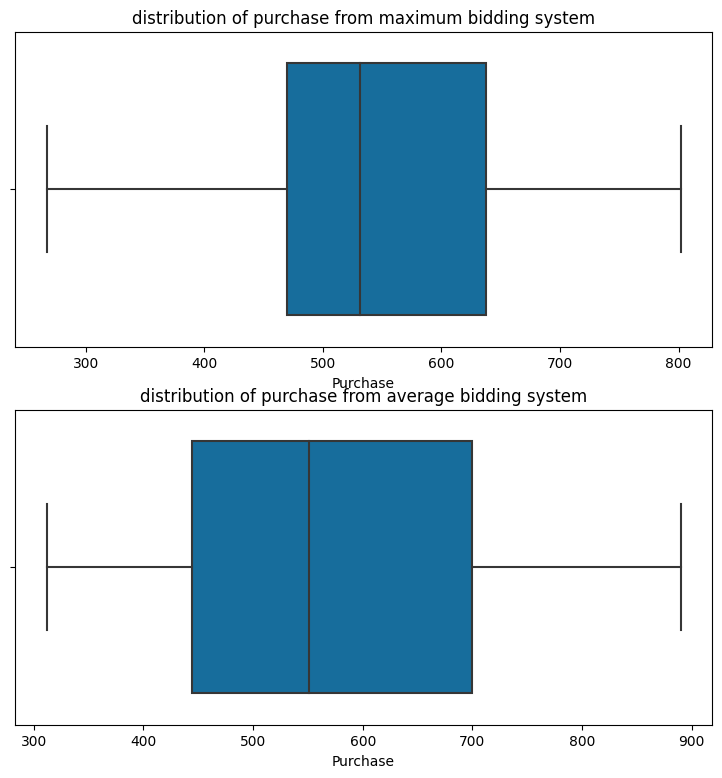

In [8]:
fig, ax = plt.subplots(2,1, figsize=(9,9))
sns.boxplot(data_control, x='Purchase', palette='colorblind', ax=ax[0])
ax[0].set_title('distribution of purchase from maximum bidding system')
sns.boxplot(data_test, x='Purchase', palette='colorblind', ax=ax[1])
ax[1].set_title('distribution of purchase from average bidding system')

**Key points:**
* Our control has lower purchases made via the current bidding system. The max purchase is almost 90 lower than the max purchase made via the new bidding system.
* The test results have higher average purchases than the current bidding system. There is also more variation seen in the standard deviation.
* We will need to conduct a a/b test to see if these higher results in the test is statistically significant.

**Steps:**
* Use shapiro to test for normality. If the p_value > 0.05 for both control and test, then the distributions are normal.
* If it is not a normal distribution, use the whitneyu method to review for normality assumption
* Use levene to test for homogenity of variances. If the p_value > 0.05 for both control and test, then this passes homogenity test.
* Use ttest_ind for t testing. If the p_value is < 0.05, then the purchases are statistically significant and therefore, we are able to reject the null hypothesis.
* Create a new data_frame with the results.

In [9]:
def ab_test(df, group, target, a, b):
    from scipy.stats import shapiro, mannwhitneyu, levene, ttest_ind
    
    groupa = df[df[group]==a][target]
    groupb = df[df[group]==b][target]
    
    #normality assumption
    normality_a = shapiro(groupa)[1] < .05
    normality_b = shapiro(groupb)[1] < .05
    # H0: distribution is normal -> [bool]==False
    # H1: distribution is not normal -> [bool]==True
    
    if (normality_a == False) & (normality_b == False):
        #parametric test assuming normality with shapiro 
        #homogeneity of variances assumption
        levene_test = levene(groupa, groupb)[1] < .05
        # H0: homogenity -> [bool]==False
        # H1: heterogenous -> [bool]==True
        
        if levene_test == False:
            ttest = ttest_ind(groupa, groupb, equal_var=True)[1]
            # H0: A = B -> [bool]==False
            # H1: A != B -> [bool]==True
        else:
            ttest = ttest_index(groupa, groupb, equal_var=False)[1]
            # H0: A = B -> [bool]==False
            # H1: A != B -> [bool]==True
    else: 
        #nonparametric test for normality
        ttest = mannwhitneyu(groupa, groupb)[1]
        # H0: A = B -> [bool]==False
        # H1: A != B -> [bool]==True
        
    #results
    table = pd.DataFrame({
                        'ab_hypothesis':[ttest<.05],
                        'p_value':[ttest]
                        })
    table['test_type'] = np.where((normality_a==False) & (normality_b==False), 'parametric', 'non-parametric')
    table['ab_hypothesis'] = np.where(table['ab_hypothesis']==False, 'fail to reject H0', 'reject H0')
    table['note'] = np.where(table['ab_hypothesis']=='fail to reject H0', 'a/b groups are similar', 'a/b groups are not similar')
    
    if (normality_a == False) & (normality_b == False):
        table['homogeneity'] = np.where(levene_test == False, 'Yes', 'No')
        table = table[['test_type','homogeneity', 'ab_hypothesis','p_value','note']]
    else:
        table = table[['test_type', 'ab_hypothesis','p_value','note']]

    print('a/b hypothesis test:', '\n', 'H0: there is no difference between the control and test', '\n', 'H1: there is a difference between the control and test')
    
    return table

ab_test(df=data, group='type', target='Purchase', a='control', b='test')

a/b hypothesis test: 
 H0: there is no difference between the control and test 
 H1: there is a difference between the control and test


,test_type,homogeneity,ab_hypothesis,p_value,note
0,parametric,Yes,fail to reject H0,0.349326,a/b groups are similar


In [10]:
data.groupby(by='type').agg({'Purchase': ['sum','count']})

Purchase      
                  sum count
type                       
control  22035.762351    40
test     23284.243866    40

# Results:
* Our control and test groups pass the normality and homogenity test. We can tell in the results because it returned as test_type = parametric & homogenity = Yes.
* The p-value is .349 and therefore we are unable to reject the null hypothesis. The difference in purchases seen between the control and test groups are not statistically significant.  

**Recommendation**
* Continue to use the current bidding system: maximum bidding. The mean purchase is close to the new bidding system while still maintaining a smaller standard deviation. In addition, we cannot conclude that the new bidding system results were statistically significant, so we might not see the increase in purchase if deployed to all users. 